In [179]:
import os
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Dataset

In [180]:
df = pd.read_csv('./dataset/train.csv')

## Data Standardization

In [181]:
mapping_fields = {
    'Row ID': 'row_id',
    'Order ID': 'order_id',
    'Order Date': 'order_date',
    'Ship Date': 'ship_date',
    'Ship Mode': 'ship_mode',
    'Customer ID': 'customer_id',
    'Customer Name': 'customer_name',
    'Segment': 'segment',
    'Country': 'country',
    'City': 'city',
    'State': 'state',
    'Postal Code': 'postal_code',
    'Region': 'region',
    'Product ID': 'product_id',
    'Category': 'category',
    'Sub-Category': 'sub_category',
    'Product Name': 'product_name',
    'Sales': 'sales'
}
columns = ["row_id", "order_id", "order_date", "ship_date", "ship_mode", "customer_id", "customer_name", "segment",
            "country", "city", "state", "postal_code", "region", "product_id", "category", "sub_category", "product_name", "sales"]

pdTmp = pd.DataFrame(df).rename(columns=mapping_fields)
pdSales = pdTmp.loc[:,columns]

for column in pdSales.select_dtypes(include=['float64']).columns:
     pdSales[column] = pdSales[column].fillna(0.0).astype('float')

for column in pdSales.select_dtypes(include=['int', 'int64']).columns:
    pdSales[column] = pdSales[column].fillna(0).astype('int')

# for column in ["order_date", "ship_date"]:
#     pdSales[column] = pd.to_datetime(pdSales[column], errors='coerce').dt.strftime('%Y-%m-%d')
pdSales["order_date"] = pd.to_datetime(pdSales["order_date"], errors='coerce').dt.strftime('%Y-%m-%d')
pdSales["order_ym"] = pd.to_datetime(pdSales["order_date"], errors='coerce').dt.strftime('%Y-%m')
pdSales["order_short_ym"] = pd.to_datetime(pdSales["order_date"], errors='coerce').dt.strftime('%y%m')
pdSales["ship_date"] = pd.to_datetime(pdSales["ship_date"], errors='coerce').dt.strftime('%Y-%m-%d')
pdSales["ship_ym"] = pd.to_datetime(pdSales["ship_date"], errors='coerce').dt.strftime('%Y-%m')
pdSales['order_quarter'] = pd.PeriodIndex(pd.to_datetime(pdSales["order_date"], errors='coerce'), freq='Q')

str_columns = ["ship_mode", "customer_id", "customer_name", "segment",
            "country", "city", "state", "region", "product_id", "category", "sub_category", "product_name"]

for column in str_columns:
     pdSales[column] = pdSales[column].fillna('').astype('str')


## #1. Average revenue in the last 3 months.

   order_ym       sales
47  2018-12  177.443102
46  2018-11  238.475989
45  2018-10  240.813096


/Users/duy.mai/.local/share/virtualenvs/sales-detection-4vP-Dp_b/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


Text(0.5, 0, 'Year')

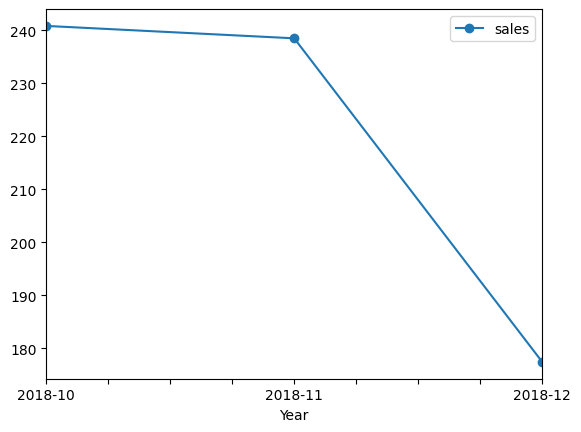

In [182]:
pdInfo = pdSales[['order_ym', 'sales']].groupby(['order_ym'])['sales'].mean()      
pdInfo = pdInfo.reset_index()
pdInfo = pdInfo.sort_values(by='order_ym', ascending=False).head(3)
print(pdInfo)
ax = pdInfo.sort_values(by='order_ym').plot.line(x='order_ym', y='sales', style='o-')
ax.set_xlabel("Year")

## #2. Quarterly sales chart

In [183]:
pdInfo = pdSales[['order_quarter', 'sales']].groupby(['order_quarter'])['sales'].sum().round(2)   
pdInfo = pdInfo.reset_index()
pdMaxInfo = pdInfo[['order_quarter', 'sales']].groupby(['order_quarter'])['sales'].max()   
pdMaxInfo = pdMaxInfo.reset_index()
pdMaxInfo = pdMaxInfo.sort_values(by='sales', ascending=False).head(1)


(array([ 80000., 100000., 120000., 140000., 160000., 180000., 200000.,
        220000., 240000., 260000.]),
 [Text(0, 80000.0, '80000'),
  Text(0, 100000.0, '100000'),
  Text(0, 120000.0, '120000'),
  Text(0, 140000.0, '140000'),
  Text(0, 160000.0, '160000'),
  Text(0, 180000.0, '180000'),
  Text(0, 200000.0, '200000'),
  Text(0, 220000.0, '220000'),
  Text(0, 240000.0, '240000'),
  Text(0, 260000.0, '260000')])

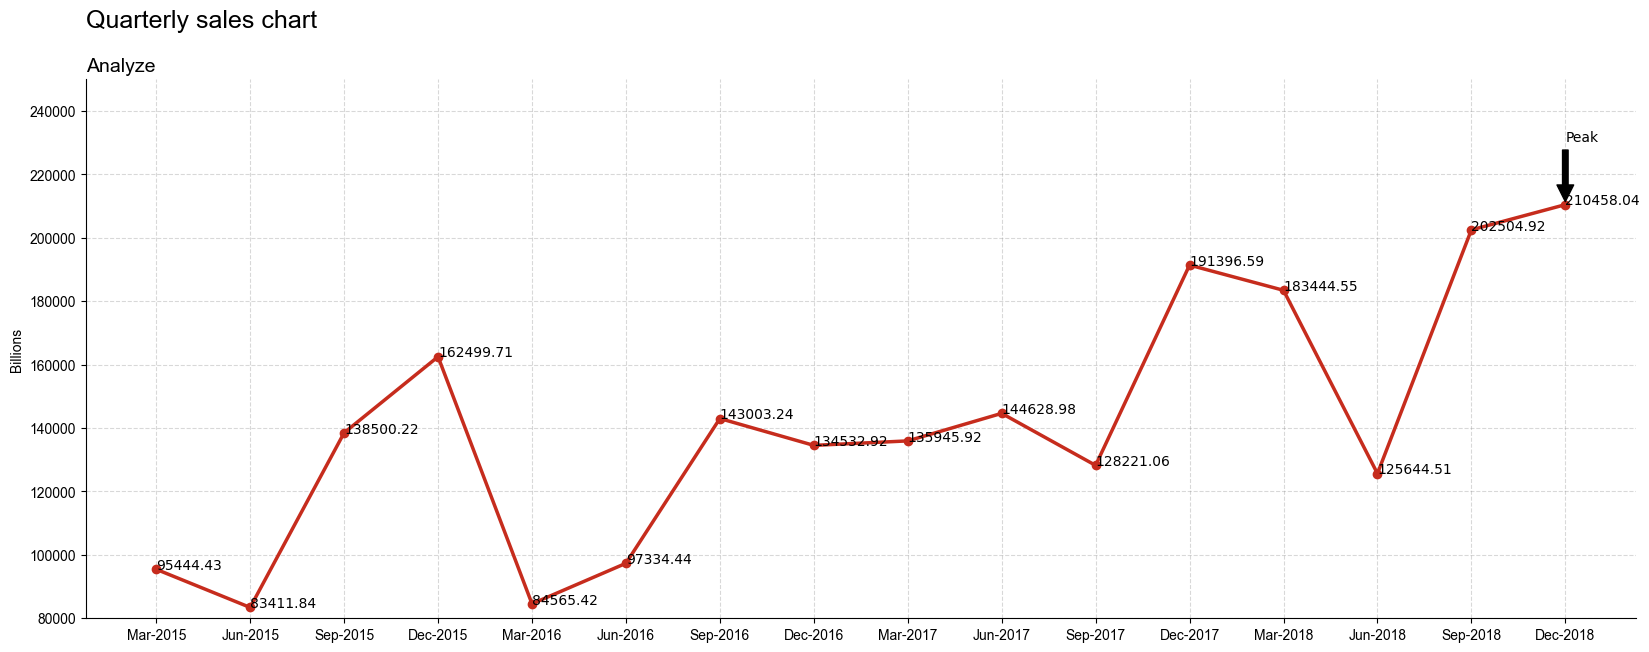

In [184]:
# font from OS
hfont = {'fontname':'Arial'}

# data
quarter = pdInfo["order_quarter"].dt.strftime('%b-%Y').tolist()
sales = pdInfo['sales'].tolist()

max_order_quarter = pdMaxInfo["order_quarter"].dt.strftime('%b-%Y').tolist()[0]
max_sale = pdMaxInfo["sales"].tolist()[0]
idxX = quarter.index(max_order_quarter)
#idxY = sales.index(max_sale)
idxY = max_sale
# plot
fig, ax = plt.subplots(1, figsize=(20,7))

plt.plot(quarter, sales, color='#C62C1D', lw=2.5, marker='o')
plt.ylim(80000,250000)

# arrow and box for annotations
arrowprops = dict(arrowstyle="wedge,tail_width=0.5", alpha=0.7, color='w')
bbox=dict(boxstyle="round", alpha=0.7, color='w')

# annotations
plt.annotate('Peak', 
             xy=(idxX, idxY),
             xytext=(idxX, idxY+20000),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )

for i,j in zip(quarter,sales):
    ax.annotate(str(j),xy=(i,j))

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# grid
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.3)
ax.xaxis.grid(color='gray', linestyle='dashed', alpha=0.3)
# Title, subtitle, axis labels, and caption
plt.suptitle('Quarterly sales chart', x=0.125, y=0.98, 
             ha='left', fontsize=18, **hfont)
plt.title("Analyze", 
          loc='left', fontsize=14, **hfont)
plt.ylabel('Billions', **hfont)

# ticks
# plt.xticks(**hfont)
# plt.yticks(**hfont) 

## #3. Average Day Ship

In [185]:
pdSales['days_order_ship'] = abs((pd.to_datetime(pdSales["order_date"], errors='coerce') - pd.to_datetime(pdSales["ship_date"])).dt.days)
pdInfo = pdSales[['order_short_ym', 'days_order_ship']].groupby(['order_short_ym'])['days_order_ship'].mean().round(2)   
pdInfo = pdInfo.reset_index()

(array([ 30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110.]),
 [Text(0, 30.0, '30'),
  Text(0, 40.0, '40'),
  Text(0, 50.0, '50'),
  Text(0, 60.0, '60'),
  Text(0, 70.0, '70'),
  Text(0, 80.0, '80'),
  Text(0, 90.0, '90'),
  Text(0, 100.0, '100'),
  Text(0, 110.0, '110')])

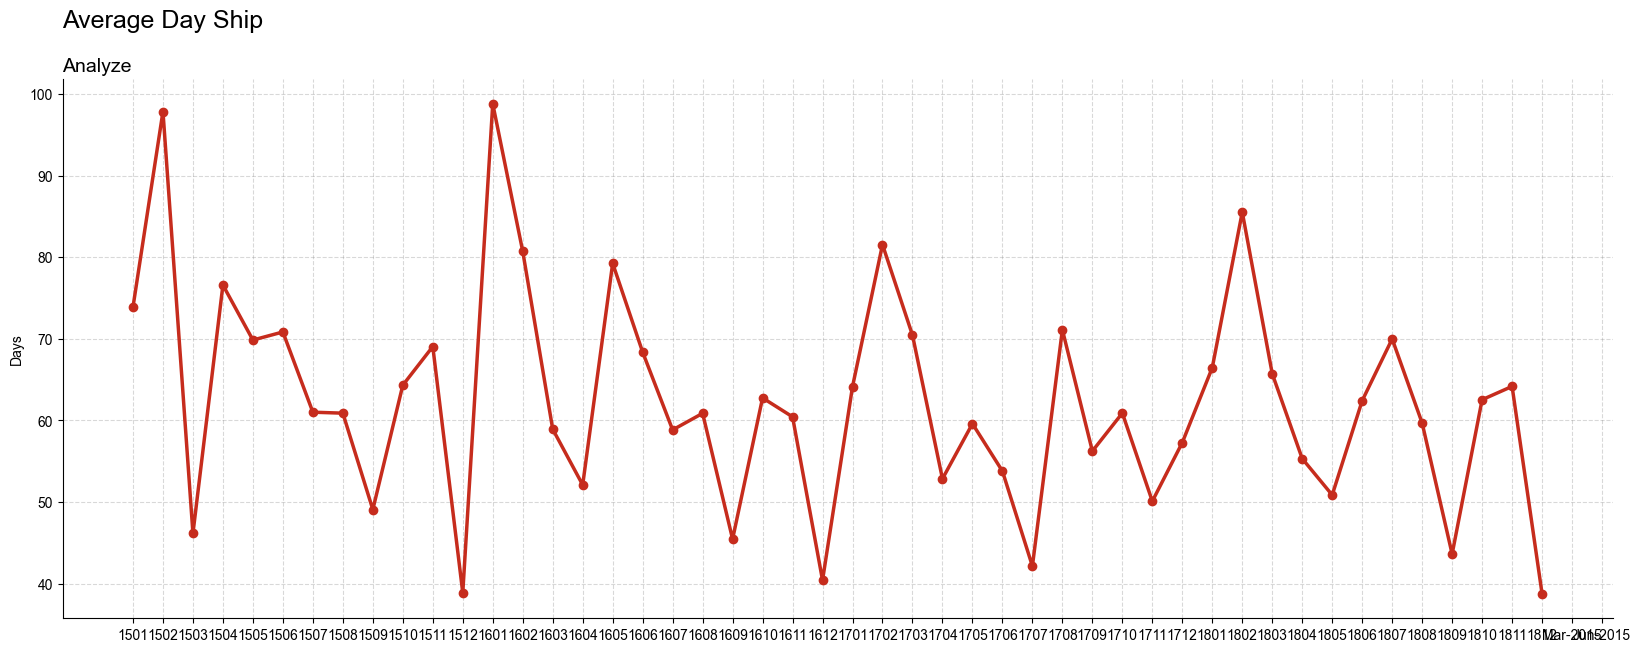

In [186]:
# data
month = pdInfo["order_short_ym"].tolist()
days = pdInfo['days_order_ship'].tolist()

# plot
fig, ax = plt.subplots(1, figsize=(20,7))

plt.plot(month, days, color='#C62C1D', lw=2.5, marker='o')
#plt.ylim(80000,250000)

# arrow and box for annotations
arrowprops = dict(arrowstyle="wedge,tail_width=0.5", alpha=0.7, color='w')
bbox=dict(boxstyle="round", alpha=0.7, color='w')

# annotations
for i,j in zip(quarter,sales):
    ax.annotate(str(j),xy=(i,j))

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# grid
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.3)
ax.xaxis.grid(color='gray', linestyle='dashed', alpha=0.3)
# Title, subtitle, axis labels, and caption
plt.suptitle('Average Day Ship', x=0.125, y=0.98, 
             ha='left', fontsize=18, **hfont)
plt.title("Analyze", 
          loc='left', fontsize=14, **hfont)
plt.ylabel('Days', **hfont)

# ticks
# plt.xticks(**hfont)
# plt.yticks(**hfont) 